## Task: Predict Carbon Emissions Based on Satellite Observations

* You are provided with a time series satellite observations dataset extracted from Sentinel-5P satelite from 2019 to 2021.

* Your objective is to build a regression model that accurately predicts the amount of carbon emossion in the next years.

* Your target is the column: "emission".

* You are provided with the code to download and load the csv file.

* Your work will be evaluated based on the completion of the given tasks below.

* You are allowed to use any models or libraries you want.
    
---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
data = pd.read_csv("/content/train.csv")
data

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.510,29.290,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.510,29.290,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79018,ID_-3.299_30.301_2021_48,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,...,5459.185355,60657.101913,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,29.404171
79019,ID_-3.299_30.301_2021_49,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,...,5606.449457,60168.191528,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,29.186497
79020,ID_-3.299_30.301_2021_50,-3.299,30.301,2021,50,NaN,NaN,NaN,NaN,NaN,...,6222.646776,56596.027209,5222.646823,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,29.131205
79021,ID_-3.299_30.301_2021_51,-3.299,30.301,2021,51,-0.000034,0.879397,-0.000028,0.184209,-100.344827,...,7896.456885,46533.348194,6946.858022,32.594768,0.274047,8.427699,48.295652,-139.447849,29.112868,28.125792


# EDA & Preprocessing

1. Drop the ID feature (ID_LAT_LON_YEAR_WEEK):

In [ ]:
# Drop ID column
data = data.drop('ID_LAT_LON_YEAR_WEEK', axis=1)

2. Check for the missing values and handle them.


In [ ]:
# Check missing values
missing_values = data.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

# Fill missing values with mean for each column
data = data.fillna(data.mean())

Columns with missing values:
SulphurDioxide_SO2_column_number_density          14609
SulphurDioxide_SO2_column_number_density_amf      14609
SulphurDioxide_SO2_slant_column_number_density    14609
SulphurDioxide_cloud_fraction                     14609
SulphurDioxide_sensor_azimuth_angle               14609
                                                  ...  
Cloud_surface_albedo                                484
Cloud_sensor_azimuth_angle                          484
Cloud_sensor_zenith_angle                           484
Cloud_solar_azimuth_angle                           484
Cloud_solar_zenith_angle                            484
Length: 70, dtype: int64


3. Plot the "emission" histogram.

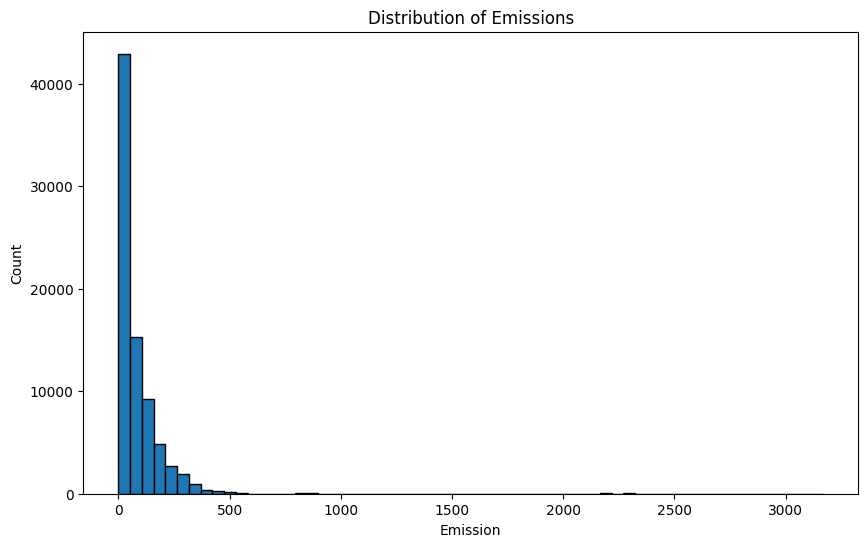

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['emission'], bins=60, edgecolor='black')
plt.title('Distribution of Emissions')
plt.xlabel('Emission')
plt.ylabel('Count')
plt.show()

3. Plot the "latitude" and "longitude" using a scatter plot then colorize the points using the "emission" column.

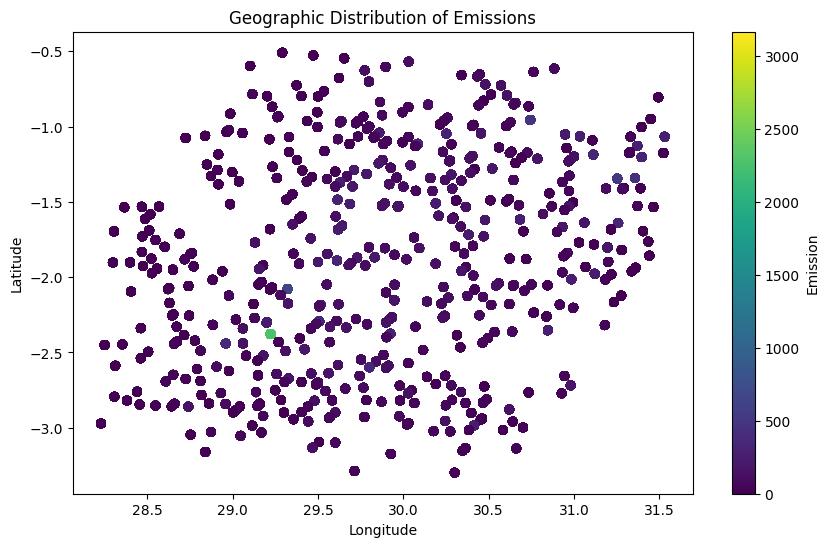

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['emission'])
plt.colorbar(label='Emission')
plt.title('Geographic Distribution of Emissions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Feature engineering

1. Add a new feature representing "Location" (To do that, you should convert "longitude" and "latitude" features to string type, concatenate them and add the result as a new feature).

In [ ]:
# Create location feature
data['Location'] = data['latitude'].astype(str) + '_' + data['longitude'].astype(str)

2. Add one aggregation feature representing the average emissions per location (You should groupby "Location" feature and take mean of the "emission", then merge the result to the data)

In [ ]:
# Calculate average emissions per location
location_avg_emission = data.groupby('Location')['emission'].mean().reset_index()
location_avg_emission.columns = ['Location', 'avg_location_emission']

# Merge back to original data
data = data.merge(location_avg_emission, on='Location', how='left')

3. Use Label encoder to encode all the categorical features

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode Location feature
le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])

# Modeling

### Baseline:

1. Create a baseline using the target median and calculate MAE score.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate baseline predictions using median
baseline_pred = data['emission'].median()
baseline_mae = mean_absolute_error(data['emission'], [baseline_pred] * len(data))
print(f"Baseline MAE: {baseline_mae:.4f}")

Baseline MAE: 67.1010


2. Perform a Time-Based Train-Test Split:
  * You will use the "year" column to split data manually using pandas.
  * Use all samples from 2019 and 2020 as the training set.
  * Use all samples from 2021 as the validation set.
  * Construct X_train, X_valid, y_train, y_valid

In [ ]:
# Split data
train_data = data[data['year'].isin([2019, 2020])]
valid_data = data[data['year'] == 2021]

# Prepare features and target
features = [col for col in data.columns if col != 'emission']
X_train = train_data[features]
y_train = train_data['emission']
X_valid = valid_data[features]
y_valid = valid_data['emission']

3. Train a LGBMRegressor on the training data.

In [ ]:
from lightgbm import LGBMRegressor

# Initialize and train model
model = LGBMRegressor(random_state=42, verbose=-1)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(random_state=42, verbose=-1)

4. Evaluate the Model on the validation data Using MAE

In [ ]:
# Make predictions and calculate MAE
valid_pred = model.predict(X_valid)
model_mae = mean_absolute_error(y_valid, valid_pred)
print(f"Model MAE: {model_mae:.4f}")

Model MAE: 11.5707


5. Plot the features importance of your model.

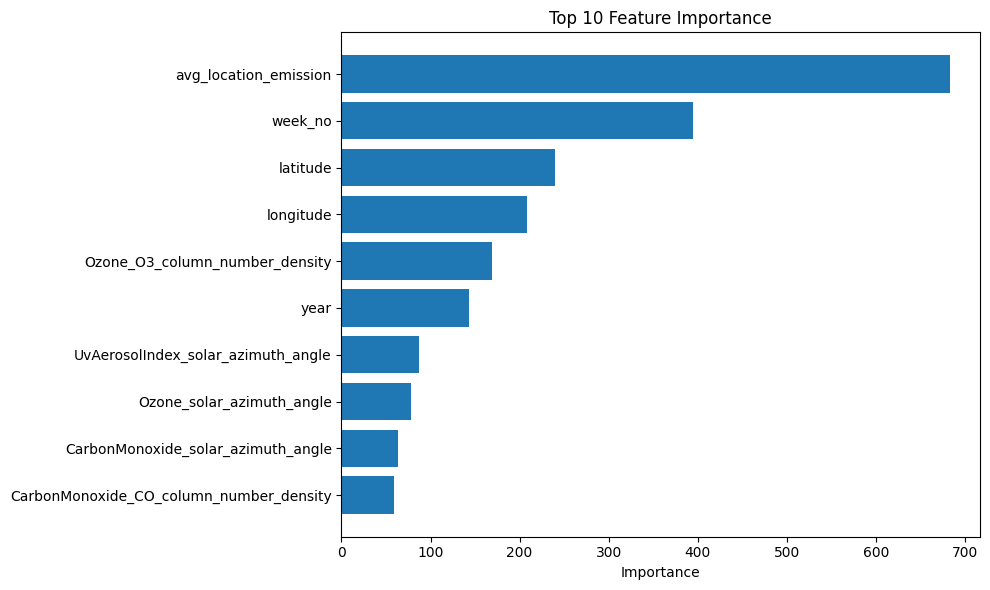

In [ ]:
# Plot feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
importance = importance.sort_values('importance', ascending=True).tail(10)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

6. Plot the validation predictions using a histogram.

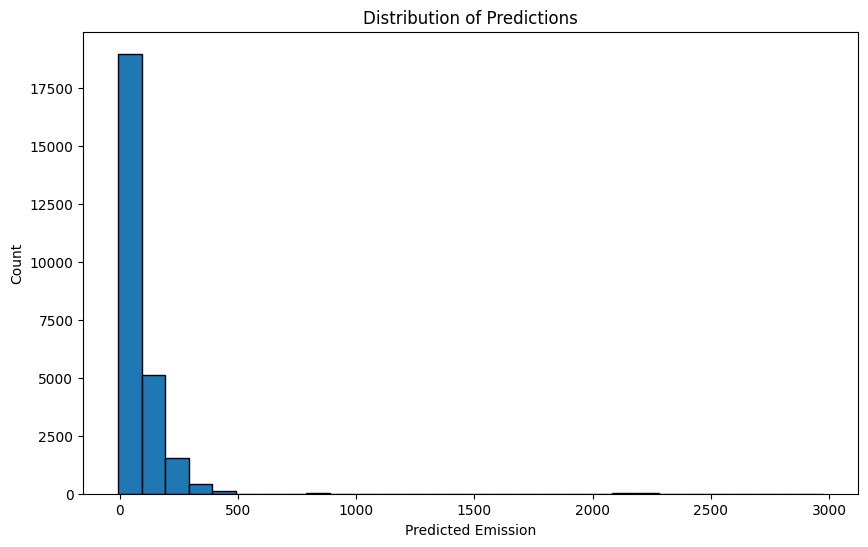

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(valid_pred, bins=30, edgecolor='black')
plt.title('Distribution of Predictions')
plt.xlabel('Predicted Emission')
plt.ylabel('Count')
plt.show()